In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [2]:
train.shape

(891, 12)

In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

#### We look at the number of people survived or died based on different variables like Gender, Embarkment Point and Travel Class

In [5]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

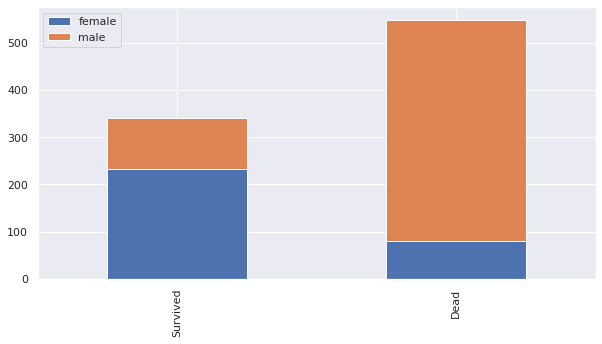

In [6]:
bar_chart('Sex')#Male Died more compared to Female

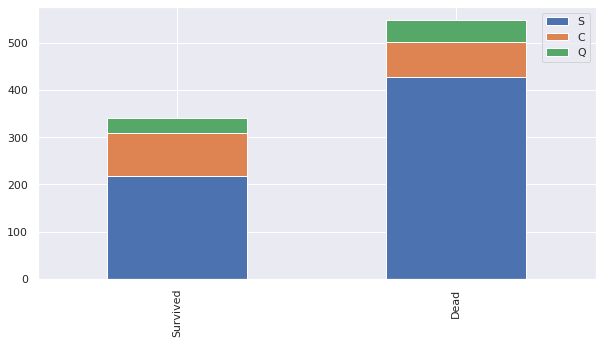

In [7]:
bar_chart('Embarked')#High number of deaths from S but also seems proportion of people from S is higher.

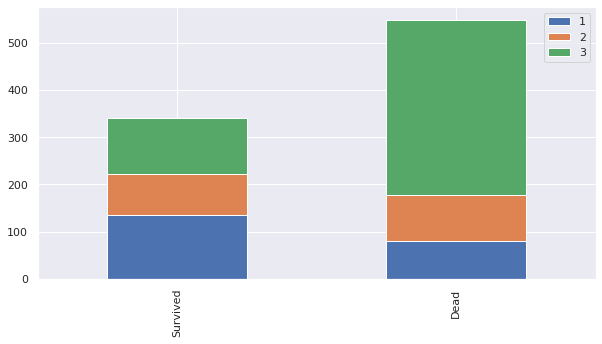

In [8]:
bar_chart('Pclass')#1st class mostly safe, 3rd class has highest casuality.

## Feature Engineering

#### Below we extract the Gender/Age group from the Name. We have 177 age value missing, for imputation it would help if we can group age groups especially for children to impute these values. 

In [9]:
train_test_data = [train, test] # combining train and test dataset to apply engineering operations

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)#False expand to return DF

In [10]:
dataset[['Name','Title']]

,Name,Title
0,"Kelly, Mr. James",Mr
1,"Wilkes, Mrs. James (Ellen Needs)",Mrs
2,"Myles, Mr. Thomas Francis",Mr
3,"Wirz, Mr. Albert",Mr
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",Mrs
...,...,...
413,"Spector, Mr. Woolf",Mr
414,"Oliva y Ocana, Dona. Fermina",Dona
415,"Saether, Mr. Simon Sivertsen",Mr
416,"Ware, Mr. Frederick",Mr


In [11]:
for dataset in train_test_data:
    print(dataset['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


#### We obtained huge list of unique title values. Hence, we categorize them into 4 categories as below

In [12]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)


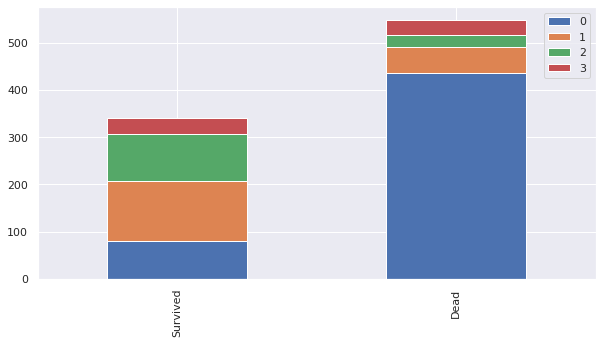

In [13]:
bar_chart('Title')#Many Mr. died

## Missing Values

In [14]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [15]:
# fill missing age with median age for each title (Mr, Mrs, Miss, Others)
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [16]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')#Since Mode is S and only two rows are missing    

## Data Wrangling

In [17]:
train['Sex'] = train['Sex'].map({'female':0,'male':1}).astype(np.int)
test['Sex'] = test['Sex'].map({'female':0,'male':1}).astype(np.int)

#### We convert Age and Fare to categorical variables to use lesser number of values and give more meaning to the model

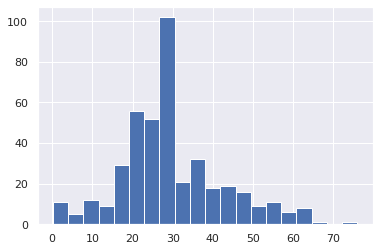

In [18]:
dataset['Age'].hist(bins=20)

In [19]:
dataset['Age'].describe()

count    418.000000
mean      29.660287
std       12.955328
min        0.170000
25%       22.000000
50%       28.500000
75%       36.500000
max       76.000000
Name: Age, dtype: float64

In [20]:
for dataset in train_test_data:#To enumerate over training and test dataset
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [21]:
dataset['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [22]:
#Converting Fare into Categorical Fare
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

#### We can further observe that the people in the category of tickets costing <= 17 were the ones most affected

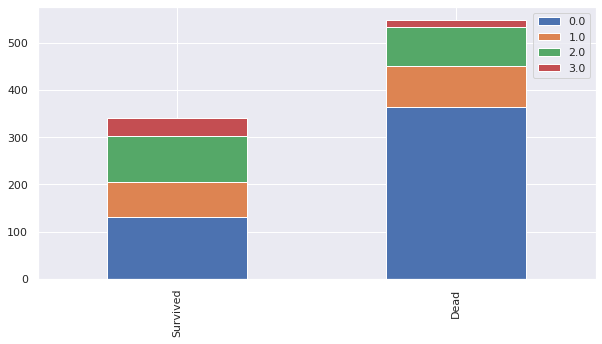

In [23]:
bar_chart('Fare')#Cheap tickets dead more.

#### Below we transform embarked to numerical representation

In [24]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [25]:
# delete unnecessary feature from dataset
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)
train_X = train.drop(['PassengerId','Cabin','Ticket','Survived'],axis=1)
train_y = train['Survived']
test_X = test.drop(['PassengerId','Cabin','Ticket'],axis=1)

In [26]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_y, test_size = 0.3, random_state = 1)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [28]:
model_logr = LogisticRegression(max_iter=400,penalty='l2',solver='liblinear')
model_logr.fit(X_train,y_train)
accuracy = model_logr.score(X_test,y_test)
accuracy

0.7947761194029851

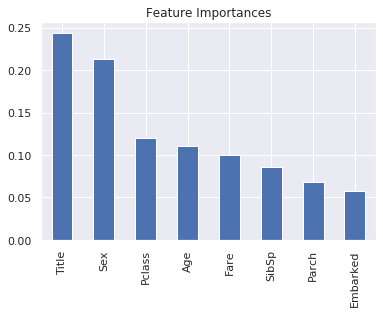

In [29]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)
coef_rf = pd.Series(model_rf.feature_importances_, X_train.columns).sort_values(ascending=False)
coef_rf.plot(kind='bar', title='Feature Importances')

In [30]:
accuracy = model_rf.score(X_test,y_test)
accuracy

0.753731343283582

In [31]:
model_xg = xgb.XGBClassifier(objective ='reg:logistic')
model_xg.fit(X_train,y_train)
accuracy = model_xg.score(X_test,y_test)
accuracy

0.7835820895522388

## Hypertuning: XG Boost

In [32]:
from sklearn.model_selection import RandomizedSearchCV

params_xg = {
        
        'max_depth': [2, 3, 4,5,6, 7,8],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        #'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        #'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        #'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        #'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.1, 0.3],
        'reg_lambda': [0.1, 1.0, 5.0],
        'n_estimators': [25,50,100,200,400]}

In [33]:
model_randomized = xgb.XGBClassifier()
model_xg_randomized = RandomizedSearchCV(estimator = model_randomized, param_distributions = params_xg, n_iter = 200, cv = 3, verbose=2, random_state=1, n_jobs = -1)# Fit the random search model
model_xg_randomized.fit(X_train, y_train)
model_xg_randomized.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   11.1s finished


{'reg_lambda': 0.1,
 'n_estimators': 25,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.3}

In [34]:
model_xg = xgb.XGBClassifier(objective ='reg:logistic',n_estimators=25,reg_lambda=0.1,max_depth=4,learning_rate=0.2,gama=0.3)
model_xg.fit(X_train,y_train)
accuracy = model_xg.score(X_test,y_test)
accuracy

0.7947761194029851

### Hence, the best performing model was XG Boost, and we use it to make the predictions below

In [35]:
IDcol = ['PassengerId']
target = 'Survived'
test[target] = model_xg.predict(test_X)
IDcol.append(target)
final = test[IDcol]
submission = pd.DataFrame({ x: test[x] for x in IDcol})
final.to_csv('solution_titanic.csv', index=False)